### Overview of the target for patent documents to get market perspective

#### Import modules

In [1]:
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import string

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 400
sns.set(style='white')

### Loading data files

In [4]:
DATA_DIR = '../data/patent_dumps'
FIG_DIR = '../data/figures'

In [5]:
rare_disease_data = pd.read_csv(f'{DATA_DIR}/orphanet_gene_enumerated_patent_data.tsv', sep='\t')
rare_disease_data.head(2)

,chembl,surechembl,patent_id,date,ipc,assignee,organization_name,acquired_by,person,genes
0,CHEMBL3137316,SCHEMBL1707427,US-20140316139-A1,2014-10-23,C07D 213/89,PFIZER,Pfizer,NaN,NaN,"IL6, NR3C1"
1,CHEMBL3137316,SCHEMBL1707427,US-20140142316-A1,2014-05-22,C07D 213/89,PFIZER,Pfizer,NaN,NaN,"IL6, NR3C1"


In [6]:
alzheimer_disease_data = pd.read_csv(f'{DATA_DIR}/ad_gene_enumerated_patent_data.tsv', sep='\t')
alzheimer_disease_data.head(2)

,chembl,surechembl,patent_id,date,ipc,assignee,organization_name,acquired_by,person,genes
0,CHEMBL1460470,SCHEMBL14919618,US-20140256767-A1,2014-09-11,C07D 401/14,UNIV RUTGERS,Rutgers University,NaN,NaN,"DUSP3, PTPN7, POLB"
1,CHEMBL1460470,SCHEMBL14919618,US-20180148408-A1,2018-05-31,C07D 209/48,UNIV RUTGERS,Rutgers University,NaN,NaN,"DUSP3, PTPN7, POLB"


Drop patents with no assignee names

In [7]:
rare_disease_data.shape, alzheimer_disease_data.shape

((17506, 10), (76321, 10))

In [8]:
rare_disease_data = rare_disease_data[~rare_disease_data['assignee'].isna()]
rare_disease_data.shape

(17375, 10)

In [9]:
alzheimer_disease_data = alzheimer_disease_data[~alzheimer_disease_data['assignee'].isna()]
alzheimer_disease_data.shape

(75616, 10)

### Genes per year according to patents

In [10]:
def gene_per_year(df: pd.DataFrame):
    """Create gene found in each year dataframe."""
    
    year_dict = defaultdict(lambda: defaultdict(set))
    
    for patent_idx, date, assignee, genes in tqdm(
        df[['patent_id', 'date', 'assignee', 'genes']].values
    ):
        year = date.split("-")[0]
        
        for gene in genes.split(', '):
            year_dict[year][gene].add(patent_idx)
        
    data = []
    for year, gene_based_dict in year_dict.items():
        # Get total patent count
        all_patents = set()
        for patents in gene_based_dict.values():
            all_patents.update(patents)
        
        data.append({
            'year': int(year),
            'total_patent_count': len(all_patents),
            'total_gene_count': len(gene_based_dict)
        })
        
    return pd.DataFrame(data)

In [11]:
rare_disease_targets_per_year = gene_per_year(rare_disease_data)
rare_disease_targets_per_year.sort_values(
    by='year', inplace=True
)
rare_disease_targets_per_year.head(1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17375/17375 [00:00<00:00, 528420.32it/s]


,year,total_patent_count,total_gene_count
21,2000,7,3


In [12]:
alzheimers_disease_targets_per_year = gene_per_year(alzheimer_disease_data)
alzheimers_disease_targets_per_year.sort_values(
     by='year', inplace=True
)
alzheimers_disease_targets_per_year.head(1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 75616/75616 [00:00<00:00, 495310.14it/s]


,year,total_patent_count,total_gene_count
14,2000,201,115


Visualisation

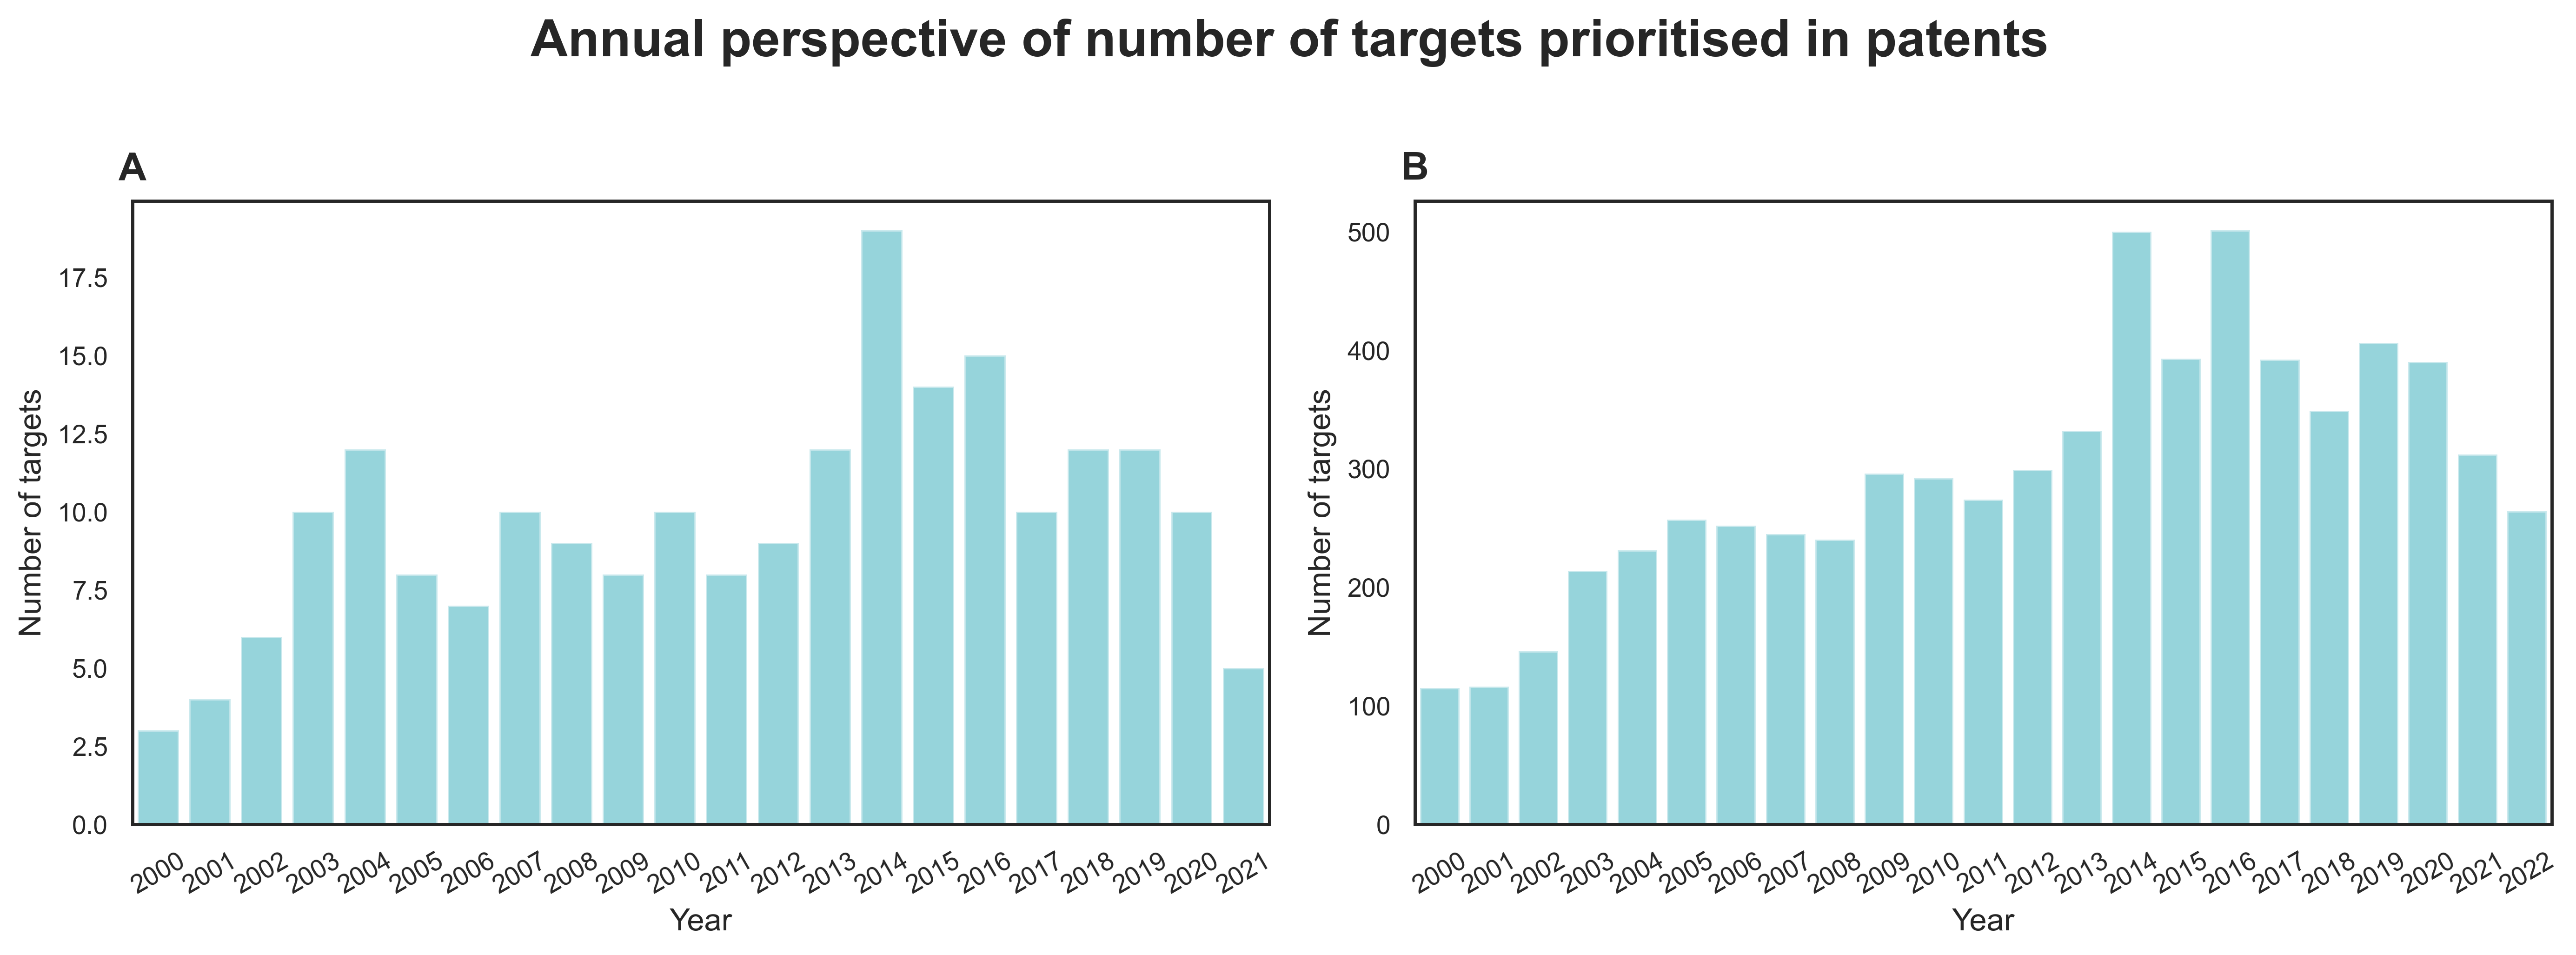

In [13]:
plt.figure(figsize=(14, 5))

plt.subplots_adjust(wspace=0)

subtitle = plt.suptitle(
    'Annual perspective of number of targets prioritised in patents', 
    y=1.02,
    fontweight='bold',
    fontsize=20
)

plt.subplot(1,2,1)
sns.barplot(
    data=rare_disease_targets_per_year, 
    x='year', y='total_gene_count',
    alpha=0.5,
    color='tab:cyan',
)

plt.xlabel('Year', size=12)
plt.ylabel('Number of targets', size=12)
plt.xticks(fontsize=10, rotation=30)
plt.yticks(fontsize=10)
plt.text(0, 1.05, string.ascii_uppercase[0],  
    size=15, weight='bold', horizontalalignment='center',
    verticalalignment='center',
    transform = plt.gca().transAxes)


plt.subplot(1,2,2)
sns.barplot(
    data=alzheimers_disease_targets_per_year, 
    x='year', y='total_gene_count',
    alpha=0.5,
    color='tab:cyan',
)

plt.xlabel('Year', size=12)
plt.ylabel('Number of targets', size=12)
plt.xticks(fontsize=10, rotation=30)
plt.yticks(fontsize=10)
plt.text(0, 1.05, string.ascii_uppercase[1],  
    size=15, weight='bold', horizontalalignment='center',
    verticalalignment='center',
    transform = plt.gca().transAxes)

plt.tight_layout(pad=1)

plt.savefig(
    f'{FIG_DIR}/supplementary_figure_3.png',
    dpi=400,
    bbox_inches='tight', 
)

plt.show()

### Ranking of targets based on patent documents

In [14]:
def create_target_rank(df: pd.DataFrame, genes_of_interest: list):
    """Create target dataframe based on the no.of patent documents linked."""
    
    patent_dict = defaultdict(lambda: defaultdict(set))
    
    for patent_idx, date, assignee, genes in tqdm(
        df[['patent_id', 'date', 'assignee', 'genes']].values
    ):
        year = date.split("-")[0]
        
        for gene in genes.split(', '):
            patent_dict[gene][year].add(patent_idx)
        
    patent_data = []
    for gene, year_based_dict in patent_dict.items():
        if gene not in genes_of_interest:
            continue
        
        # Get total patent count
        all_patents = set()
        for patents in year_based_dict.values():
            all_patents.update(patents)
        
        for year, year_patents in year_based_dict.items():
            patent_data.append({
                'Gene': gene,
                'total_patent_count': len(all_patents),
                'year': int(year),
                'annual_patent_count': len(year_patents)
            })
        
    return pd.DataFrame(patent_data)

In [15]:
rare_disease_eg_genes = ['PYGL', 'VCP', 'DAO']
rare_disease_target_rank = create_target_rank(rare_disease_data, rare_disease_eg_genes)
rare_disease_target_rank.sort_values(
    by=['total_patent_count', 'year'], ascending=[False, True], inplace=True
)
rare_disease_target_rank.head(1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17375/17375 [00:00<00:00, 517773.00it/s]


,Gene,total_patent_count,year,annual_patent_count
36,DAO,127,2002,1


In [16]:
ad_case_1 = ['RET', 'INSR', 'SLC5A1']
ad_case_2 = ['ADAM17', 'BACE1']
ad_case_3 = ['ELANE']

In [17]:
alzheimers_disease_target_rank_1 = create_target_rank(alzheimer_disease_data, ad_case_1)
alzheimers_disease_target_rank_1.sort_values(
     by=['total_patent_count', 'year'], ascending=[False, True], inplace=True
)

alzheimers_disease_target_rank_2 = create_target_rank(alzheimer_disease_data, ad_case_2)
alzheimers_disease_target_rank_2.sort_values(
     by=['total_patent_count', 'year'], ascending=[False, True], inplace=True
)

alzheimers_disease_target_rank_3 = create_target_rank(alzheimer_disease_data, ad_case_3)
alzheimers_disease_target_rank_3.sort_values(
     by=['total_patent_count', 'year'], ascending=[False, True], inplace=True
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 75616/75616 [00:00<00:00, 419212.52it/s]


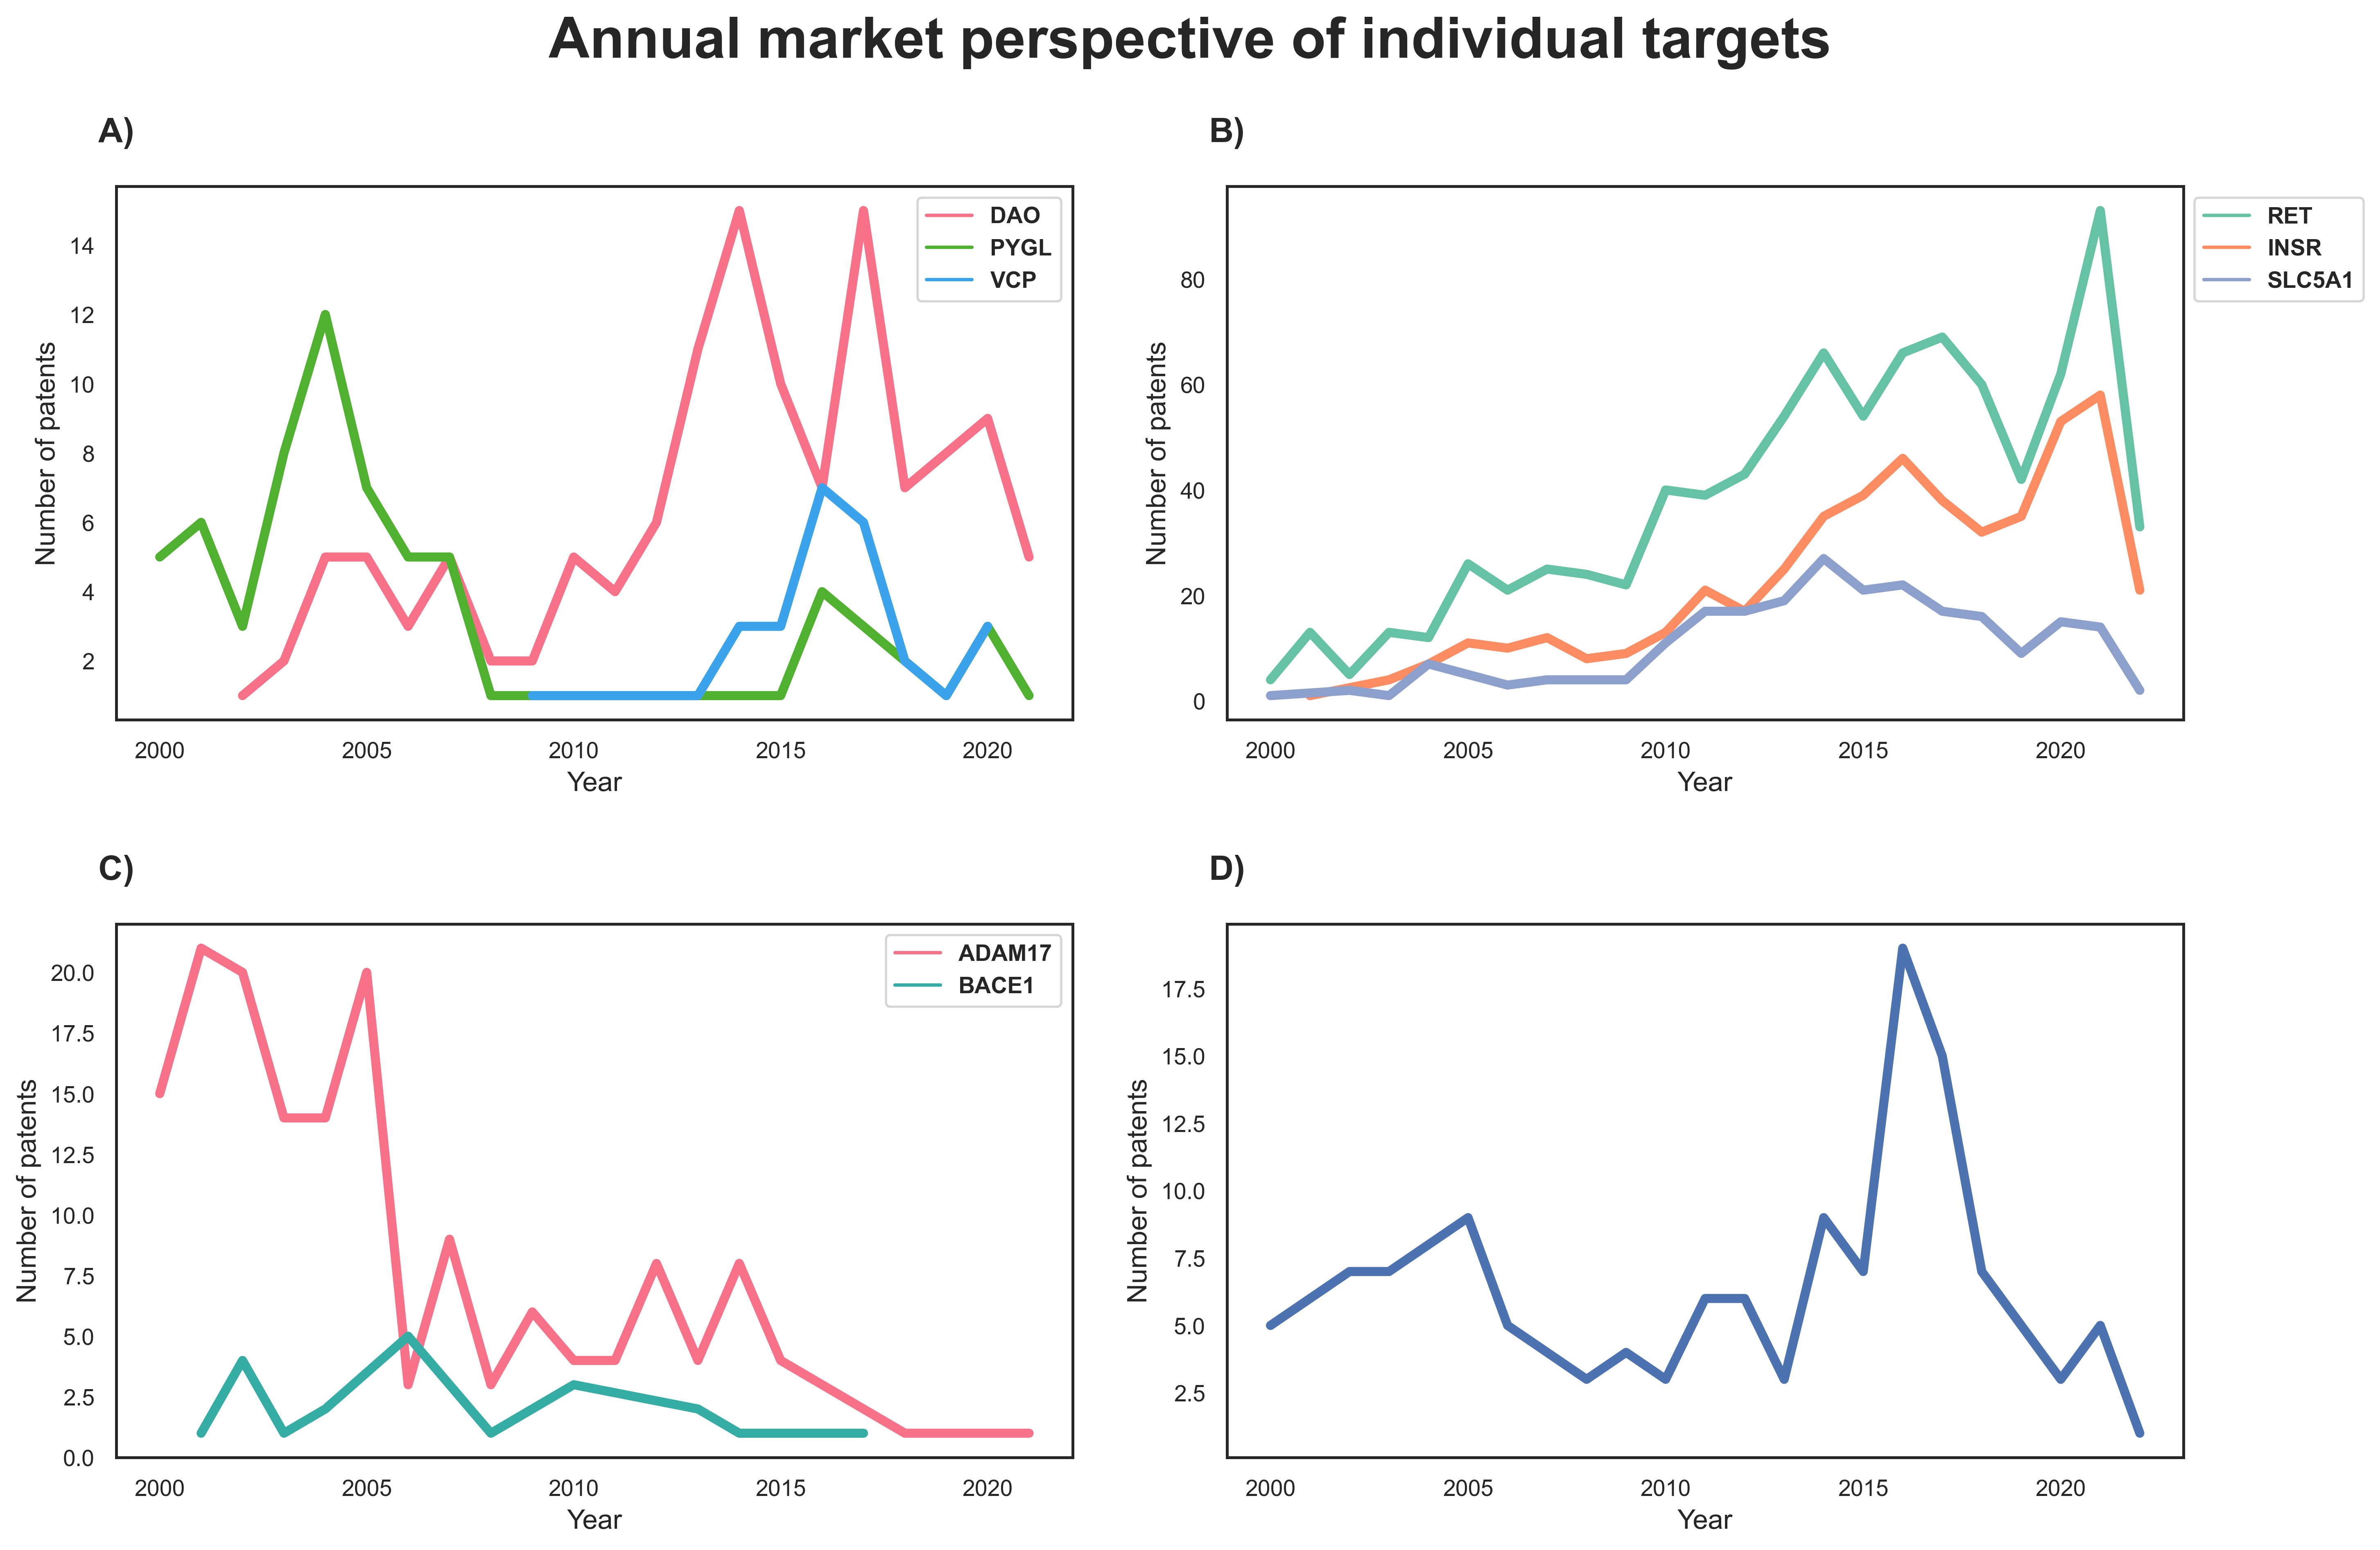

In [18]:
plt.figure(figsize=(15, 10))

plt.subplots_adjust(wspace=0)

subtitle = plt.suptitle(
    'Annual market perspective of individual targets', 
    y=0.96,
    fontweight='bold',
    fontsize=25
)

plt.subplot(2,2,1)
sns.lineplot(
    data=rare_disease_target_rank, x='year', y='annual_patent_count',
    hue='Gene', palette='husl', linewidth=4
)
plt.xlabel('Year', size=12)
plt.ylabel('Number of patents', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), prop={'size': 10, 'weight': 'bold'})
plt.text(0, 1.1, string.ascii_uppercase[0] + ')',  
        size=15, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

plt.subplot(2,2,2)
sns.lineplot(
    data=alzheimers_disease_target_rank_1, x='year', y='annual_patent_count',
    hue='Gene', palette='Set2', linewidth=4
)
plt.xlabel('Year', size=12)
plt.ylabel('Number of patents', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), prop={'size': 10, 'weight': 'bold'})
plt.text(0, 1.1, string.ascii_uppercase[1] + ')',  
        size=15, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

plt.subplot(2,2,3)
sns.lineplot(
    data=alzheimers_disease_target_rank_2, x='year', y='annual_patent_count',
    hue='Gene', palette='husl', linewidth=4
)
plt.xlabel('Year', size=12)
plt.ylabel('Number of patents', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), prop={'size': 10, 'weight': 'bold'})
plt.text(0, 1.1, string.ascii_uppercase[2] + ')',  
        size=15, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

plt.subplot(2,2,4)
sns.lineplot(
    data=alzheimers_disease_target_rank_3, 
    x='year', y='annual_patent_count', linewidth=4
)
plt.xlabel('Year', size=12)
plt.ylabel('Number of patents', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.text(0, 1.1, string.ascii_uppercase[3] + ')',  
        size=15, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)


plt.tight_layout(pad=2.0)

plt.savefig(
    f'{FIG_DIR}/figure_9.png',
    dpi=400,
    bbox_inches='tight', 
)

plt.show()